In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plts
import numpy as np
from math import floor
                                                                    
from torchvision import datasets, transforms

## set variables

In [2]:
learning_rate = 0.1
num_triplets = 10 # learning batch size
epochs = 5
margin = 0.2 # for triplet loss
device = torch.device("cpu")

## functions and classes

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3136, 64)
        self.fc2 = nn.Linear(64,10)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
        
def classify(model, x):
    return model(x).argmax(dim=1)
        

In [4]:
class Classifier():
    def __init__(self, data, classes):
        assert len(data) == len(classes), "length of data and labels must match"
        self.data = data
        self.data_size = len(data)
        self.classes = classes
        
    def classify_knn(self, x, k=5):
        labels = torch.zeros(len(x), dtype=torch.int)
        best = torch.zeros(k, dtype=int)
        distances = torch.ones((2,), dtype=torch.float64)
        
        for i in range(len(x)):
            distances = distances.new_full((1, k), float("inf")).squeeze()
            for j in range(self.data_size):
                if torch.dist(x[i], self.data[j], 2) < torch.max(distances):
                    best[torch.argmax(distances)] = self.classes[j]
                    distances[torch.argmax(distances)] = torch.dist(x[i], self.data[j], 2)
            labels[i] = torch.mode(best)[0]
            
        return labels


In [5]:
def get_triplet_idxs(imgs, labels, num, pos_alpha=1, neg_alpha=1):
    """
    find indexes of triplets for network training using triplet loss
    
    param x: images descriptors, Tensor(n, dim)
    param y: images labels, Tensor, (n, )
    param num: number of triplets to get
    
    return triplet idxs, (3, num)
    """
    
    pdist = nn.PairwiseDistance(p=2)

    triplets = -torch.ones(3,num, dtype=torch.int) 
    triplets[0] = torch.randint(size=(1, num), low=0, high=len(x)-1)
    
    for i in range(num):
        anchor_label = labels[triplets[0][i]]
        anchor_img = imgs[triplets[0][i]]
        while True:
            pos_idxs = (labels == anchor_label).nonzero().squeeze()
            neg_idxs = (labels != anchor_label).nonzero().squeeze()
            
            if len(pos_idxs) == 0 or len(neg_idxs) == 0:
                continue
                
            pos_output = pdist(anchor_img, imgs[pos_idxs])
            pos_dists = torch.argsort(pos_output, descending=False)
            triplets[1][i] = pos_idxs[floor((pos_dists.shape[0]-1)*pos_alpha)]
            
            neg_output = pdist(anchor_img, imgs[pos_idxs])
            neg_dists = torch.argsort(neg_output, descending=True)
            triplets[2][i] = neg_idxs[floor((neg_dists.shape[0]-1)*neg_alpha)]
            
            break
        break
        
    return torch.transpose(triplets, 0, 1)

In [6]:
def create_minibatch(imgs, idxs):
    """
    Create batch of images from given indexes 
    
    param imgs: images, tuple (Tensor(n, 1, 28, 28), label)
    param idxs: indexes of images to exctract, Tensor(size, 3)
    
    return anchor, positive, negative.. each Tensor(size, 1, 28, 28)
    """
    anchor = torch.ones(len(idxs),1, 28, 28)
    positive = torch.ones(len(idxs),1, 28, 28)
    negative = torch.ones(len(idxs),1, 28, 28)
    for i in range(len(idxs)):
        anchor[i] = imgs[idxs[i][0]][0]
        positive[i] = imgs[idxs[i][1]][0]
        negative[i] = imgs[idxs[i][2]][0]
    return anchor, positive, negative



In [7]:
tst_transformation = transforms.Compose([transforms.ToTensor()])
trn_data = datasets.MNIST("", download=True, train=True, transform= tst_transformation)
tst_data = datasets.MNIST("", download=True, train=False, transform= tst_transformation)

net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

bs = 10*num_triplets
trn_loader = torch.utils.data.DataLoader(trn_data, batch_size=bs, shuffle=True)
tst_loader = torch.utils.data.DataLoader(tst_data, batch_size=bs, shuffle=True)

## training proceess

In [ ]:
pos_distances = []
neg_distances = []
trn_loss = []
tst_loss = []
pdist = nn.PairwiseDistance(p=2)
pos_dist = 0
neg_dist = 0

for epoch in range(epochs):
    print(epoch+1, '/', epochs)

    for i_batch, (x,y) in enumerate(trn_loader):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            net.eval()
            output = net(x)
            idxs = get_triplet_idxs(output, y, num_triplets,0,0)
            anchor, positive, negative = create_minibatch(x, idxs)
        
        
        net.train()
        optimizer.zero_grad()
        anchor_output = net(anchor)
        positive_output = net(positive)
        negative_output = net(negative)
        pos_dist += torch.sum(pdist(anchor_output, positive_output))
        neg_dist += torch.sum(pdist(anchor_output, negative_output))

        loss = F.triplet_margin_loss(anchor_output, positive_output, negative_output, margin)
        optimizer.step()

        if i_batch % (len(trn_loader.dataset)/(bs*10)) == 0:
            trn_loss.append(loss.item())
            pos_distances.append(pos_dist/len(trn_loader))
            neg_distances.append(neg_dist/len(trn_loader))
            pos_dist = 0
            neg_dist = 0
    
    with torch.no_grad():
        for i_batch, (x,y) in enumerate(tst_loader):
            x, y = x.to(device), y.to(device)
            if i_batch % (len(tst_loader.dataset)/(bs*10)) == 0:
                loss = F.nll_loss(net(x), y)
                output = net(x)
                idxs = get_triplet_idxs(output, y, num_triplets)
                anchor, positive, negative = create_minibatch(x, idxs)
                loss = F.triplet_margin_loss(net(anchor), net(positive), net(negative), margin)
                tst_loss.append(loss.item())
        

1 / 5


red is train, green is test


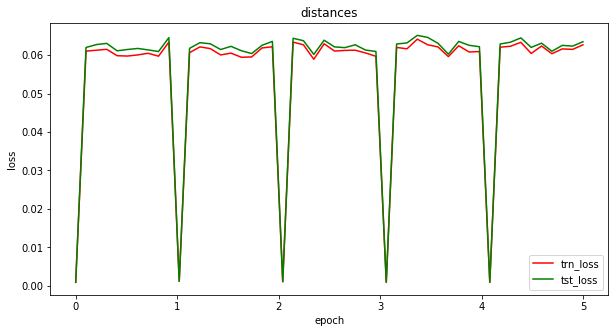

In [10]:
x = np.linspace(0, epochs, len(pos_distances))
print('red is train, green is test')
plt.figure(figsize=(10, 5))
plt.title("distances")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(x, pos_distances, 'r', label='positive distance')
plt.plot(x, neg_distances, 'g', label='negative distance')
plt.legend()
plt.show()

red is train, green is test


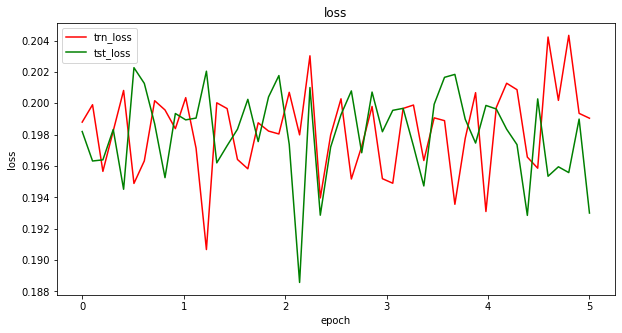

In [11]:
x = np.linspace(0, epochs, len(trn_loss))
print('red is train, green is test')
plt.figure(figsize=(10, 5))
plt.title("loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(x, trn_loss, 'r', label='trn_loss')
plt.plot(x, tst_loss, 'g', label='tst_loss')
plt.legend()
plt.show()

## classification

In [ ]:
# # on cpu
# fgf
# correct = 0
# total = len(tst_loader.dataset)

# final_loader = torch.utils.data.DataLoader(trn_data, batch_size=len(trn_loader.dataset), shuffle=True)
# for i, (x,y) in enumerate(final_loader):
#     break
#     (x)
#     print(i)
#     with torch.no_grad():
#         classifier = Classifier(net(x),y)
    
# for i, (x,y) in enumerate(final_loader):
#     break
#     output = net(x)
#     labels = classifier.classify_knn(output)
#     correct += sum(labels == y)
    
# print(correct/total)

    
